In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional     scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
 
train = pd.read_csv('df_training.csv')
#train.dropna()
target = 'TARGET'
IDcol = 'ID'


predictors = [x for x in train.columns if x not in [target,IDcol]]


D:\Software\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:

def f1_score_vail(pred, data_vail):
    labels = data_vail.get_label() 
    preds = []
    for i in pred: 
        if i > 0.5:
            preds.append(1)
        else:
            preds.append(0) 
    score_vail = f1_score(y_true=labels, y_pred=preds, average='binary')      # xgb的predict输出即为对应的label
    return '1-f1_score', 1-score_vail   # xgb目标是将目标指标降低


In [3]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['TARGET'],eval_metric='auc')

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['TARGET'].values, dtrain_predictions))
    print ("f1 : %.4g" % metrics.f1_score(dtrain['TARGET'].values, dtrain_predictions))
    print ("precesion : %.4g" % metrics.precision_score(dtrain['TARGET'].values, dtrain_predictions))
    print ("recall : %.4g" % metrics.recall_score(dtrain['TARGET'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['TARGET'], dtrain_predprob))

    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


In [161]:
param_test0 = {
 'n_estimators':range(38,42,1),
 'learning_rate':[0.1,0.11]
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.11, n_estimators=177, max_depth=7,
 min_child_weight=12, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=5,seed=27), 
 param_grid = param_test0, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.best_params_,    gsearch0.best_score_


({'learning_rate': 0.11, 'n_estimators': 39}, 0.4302634369541013)


Model Report
Accuracy : 0.9878
f1 : 0.9646
precesion : 0.9317
recall : 1
AUC Score (Train): 0.999938


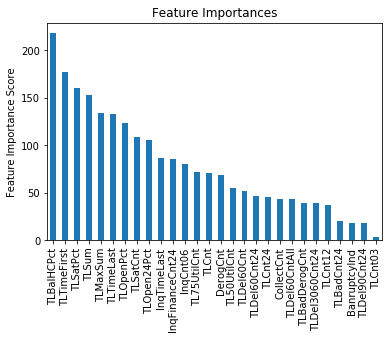

In [5]:
xgb1 = XGBClassifier(
 learning_rate =0.11,
 n_estimators=39,
 max_depth=7,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=5,
 seed=27)
modelfit(xgb1, train, predictors)

In [99]:
param_test1 = {
 'max_depth':range(2,6,1),
 'min_child_weight':range(2,5,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(         
    learning_rate =0.11, n_estimators=39, max_depth=5,
    min_child_weight=1, gamma=0, subsample=0.8,colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4,     scale_pos_weight=5, seed=27), 
    param_grid = param_test1,     scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.best_params_,     gsearch1.best_score_

({'max_depth': 4, 'min_child_weight': 3}, 0.4366027672314926)

In [100]:
param_test2 = {
 'max_depth':[3,4,5],
 'min_child_weight':[2,3,4]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(     learning_rate=0.11, n_estimators=39, max_depth=4,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=5,seed=27), 
 param_grid = param_test2, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.best_params_,     gsearch2.best_score_

({'max_depth': 4, 'min_child_weight': 3}, 0.4366027672314926)


Model Report
Accuracy : 0.8378
f1 : 0.6465
precesion : 0.5076
recall : 0.89
AUC Score (Train): 0.941560


({'min_child_weight': 3}, 0.4366027672314926)

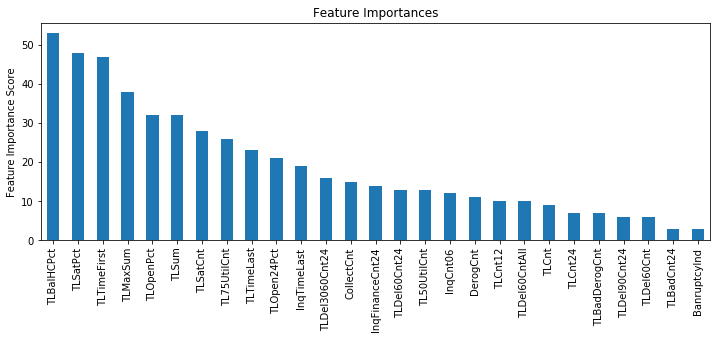

In [102]:
param_test2b = {
 'min_child_weight':[2,3,4]
 }
gsearch3 = GridSearchCV(estimator = XGBClassifier(     learning_rate=0.11, n_estimators=39, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8,     colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=5,seed=27), 
 param_grid = param_test2b,     scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
 
modelfit(gsearch3.best_estimator_, train, predictors)
gsearch3.best_params_,     gsearch3.best_score_

In [103]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.11, n_estimators=39, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=5,seed=27), 
 param_grid = param_test3, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.0}, 0.4366027672314926)


Model Report
Accuracy : 0.8378
f1 : 0.6465
precesion : 0.5076
recall : 0.89
AUC Score (Train): 0.941560


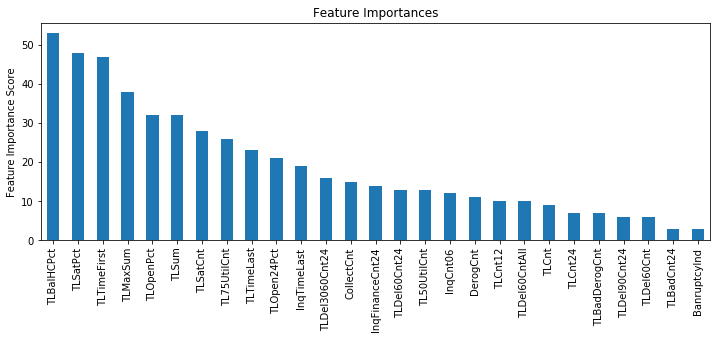

In [104]:
xgb2 = XGBClassifier(
 learning_rate =0.11,
 n_estimators=39,
 max_depth=4,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
scale_pos_weight=5,
seed=27)
modelfit(xgb2, train, predictors)

In [106]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.11, n_estimators=39, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=5,seed=27), 
 param_grid = param_test4, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.4366027672314926)

In [213]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.11, n_estimators=39, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=5,seed=27), 
 param_grid = param_test5, scoring='f1',n_jobs=5,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.4366027672314926)

In [8]:
param_test6 = {
 'reg_alpha':[1.505,1.51,1.515]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.11, n_estimators=39, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=5,seed=27), 
 param_grid = param_test6, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 1.505}, 0.42234396625632764)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.11, max_delta_step=0, max_depth=4,
       min_child_weight=3, missing=None, n_estimators=39, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=5, seed=27, silent=None,
       subsample=0.8, verbosity=1)


Model Report
Accuracy : 0.8378
f1 : 0.6465
precesion : 0.5076
recall : 0.89
AUC Score (Train): 0.941560


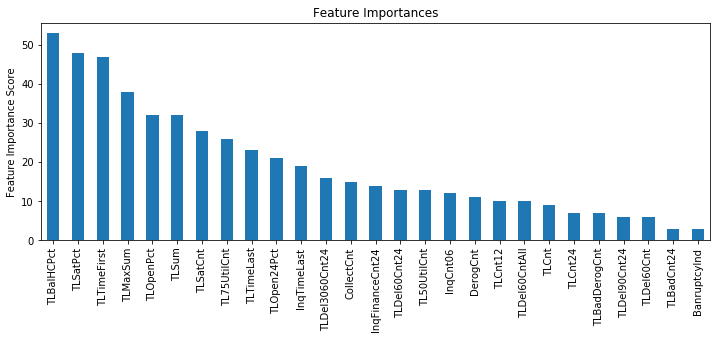

In [176]:
xgb3 = XGBClassifier(
 learning_rate =0.11,
 n_estimators=39,
 max_depth=4,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8, 
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=5,
 seed=27)
modelfit(xgb3, train, predictors)

In [214]:
test_data = pd.read_csv('df_test.csv')
y_predict = gsearch5.predict(test_data[predictors])

In [215]:
#保存预测结果
#y_predict = RF.predict(x_test_data)
#y_predict = gsearch2.predict(x_test_data)
df = pd.DataFrame(columns=['ID','Predicted_Results'])
df['ID'] = test_data.iloc[:,0]
df['Predicted_Results'] = y_predict
df.to_csv('result.csv',index=False)

In [156]:
from sklearn.ensemble import VotingClassifier


v1 = XGBClassifier( learning_rate =0.11, n_estimators=39, max_depth=4,
                     min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=1.505,
                     objective= 'binary:logistic', nthread=4, scale_pos_weight=5,seed=27)

v2 = RandomForestClassifier(n_estimators=132,max_depth=11,min_samples_split=80,min_samples_leaf=20,
                            class_weight={0: 1, 1: 5},max_features='sqrt',oob_score=True ,random_state=10)


estimators = []
# estimators.append(('RidgeClassifier', RidgeClassifier()))
#estimators.append(('LogisticRegression', LogisticRegression()))
estimators.append(('XGBClassifier', v1))
estimators.append(('AdaBoostClassifier', v2))
# estimators.append(('RandomForestClassifier', RandomForestClassifier()))

#voting: auc:0.794587, recall:0.000642, accuracy:0.944433

voting = VotingClassifier(estimators = estimators, voting='soft')
estimate(voting, 'voting')


auc 0.7561933333333334
precision 0.33076482408701335
recall 0.57
f1 0.4184655581866132


In [155]:
def estimate(estimator, name='estimator'):
    auc = cross_val_score(estimator, train_train_x, train[target], scoring='roc_auc', cv=3).mean()
    precision = cross_val_score(estimator, train_train_x, train[target], scoring='precision', cv=3).mean()
    f1 = cross_val_score(estimator, train_train_x, train[target], scoring='f1', cv=3).mean()
    recall = cross_val_score(estimator, train_train_x, train[target], scoring='recall', cv=3).mean()

    print('auc',auc)
    print('precision',precision)    
    print('recall',recall)    
    print('f1',f1)        

In [31]:

from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True)


In [2]:
train_data = train[predictors].fillna(train[predictors].median())

In [44]:
train_target = train[target]

In [37]:
voting.fit(train_data,train[target])

VotingClassifier(estimators=[('XGBClassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.11, max_delta_step=0, max_depth=4,
       min_child_weight=3, missing=None, n_estimators=39, n_jobs=1,
       nthread=4,...mators=132, n_jobs=None, oob_score=True, random_state=10,
            verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [41]:
test_data = pd.read_csv('df_test.csv')
y_predict = voting.predict(test_data[predictors].fillna(test_data[predictors].median()))

In [42]:

df = pd.DataFrame(columns=['ID','Predicted_Results'])
df['ID'] = test_data.iloc[:,0]
df['Predicted_Results'] = y_predict
df.to_csv('output/result.csv',index=False)

In [162]:
from sklearn.ensemble import BaggingClassifier
bagging_clf = BaggingClassifier(voting,n_estimators=50)
# 计算交叉验证的准确率
#scores = cross_val_score(bagging_clf, train_data, train_target, cv=3)
#print(scores.mean())
estimate(bagging_clf)

auc 0.7619266666666666
precision 0.37231040564373896
recall 0.5366666666666666
f1 0.4261993138654587


In [169]:
bagging_clf.fit(train_train_x,train[target])
y_predict = bagging_clf.predict(test_data_x)
y_predict

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,

In [170]:

df = pd.DataFrame(columns=['ID','Predicted_Results'])
df['ID'] = test_data.iloc[:,0]
df['Predicted_Results'] = y_predict
df.to_csv('output/result.csv',index=False)

In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.tree import DecisionTreeClassifier
from mlxtend.classifier import StackingClassifier
# 定义三个不同的分类器
# clf1 = KNeighborsClassifier(n_neighbors=7)
# clf2 = DecisionTreeClassifier()
# clf3 = LogisticRegression()
# # 定义一个次级分类器
meta = LogisticRegression(solver='lbfgs',class_weight='balanced')  
sclf2 = StackingClassifier(classifiers=[v1, v2], meta_classifier=meta,use_probas=True)#两层
estimate(meta)

D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Softwar

auc 0.7131333333333334
precision 0.2719857378393964
recall 0.6766666666666667
f1 0.3975204344267245


D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [117]:
sclf2.fit(train_data,train[target])

StackingClassifier(average_probas=False,
          classifiers=[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.11, max_delta_step=0, max_depth=4,
       min_child_weight=3, missing=None, n_estimators=39, n_jobs=1,
       nthread=4, objective='binar...imators=132, n_jobs=None, oob_score=True, random_state=10,
            verbose=0, warm_start=False)],
          drop_last_proba=False,
          meta_classifier=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
          store_train_meta_features=False, use_clones=True,
          use_features_in_secondary=False, use_probas=True, verbose=0)

In [118]:
y_predict = sclf2.predict(test_data[predictors].fillna(test_data[predictors].median()))

In [120]:

df = pd.DataFrame(columns=['ID','Predicted_Results'])
df['ID'] = test_data.iloc[:,0]
df['Predicted_Results'] = y_predict
df.to_csv('output/result.csv',index=False)

,DerogCnt,CollectCnt,BanruptcyInd,InqCnt06,InqTimeLast,InqFinanceCnt24,TLTimeFirst,TLTimeLast,TLCnt03,TLCnt12,...,TL50UtilCnt,TLBalHCPct,TLSatPct,TLDel3060Cnt24,TLDel90Cnt24,TLDel60CntAll,TLOpenPct,TLBadDerogCnt,TLDel60Cnt24,TLOpen24Pct
0,0,0,0,1,4.0,1,487,12,0,1,...,10.0,0.7681,0.8182,0,0,0,0.5909,0,0,0.4615
1,0,0,0,4,1.0,3,283,6,0,2,...,6.0,0.7108,0.7273,0,0,1,0.5909,0,0,0.1538
2,2,1,0,2,2.0,5,252,11,0,1,...,5.0,0.4656,0.0526,3,7,14,0.5263,9,9,0.1000
3,0,0,0,1,3.0,6,165,27,0,0,...,5.0,0.8179,0.0714,2,9,11,0.5714,9,10,0.0000
4,0,0,0,3,1.0,3,331,6,0,1,...,7.0,0.6032,0.6500,3,2,3,0.7500,2,3,0.4000


In [127]:
import lightgbm as lgb
clf =lgb.LGBMClassifier(
        boosting_type='gbdt', num_leaves=55, reg_alpha=0.0, reg_lambda=1,
        max_depth=15, n_estimators=6000, objective='binary',
        subsample=0.8, colsample_bytree=0.8, subsample_freq=1,
        learning_rate=0.06, min_child_weight=1, random_state=20, n_jobs=4
    )
#cross_val_score(clf,train_data,train[target])
estimate(clf)

auc 0.7012733333333333
precision 0.41795148525028264
recall 0.25333333333333335
f1 0.2497687420930201


In [4]:
from sklearn.preprocessing import StandardScaler

#X_train = train_master.drop(['TARGET'], axis=1)

train_train_x = StandardScaler().fit_transform(train_data)


D:\Software\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Software\Anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [146]:
train_data.head()

,DerogCnt,CollectCnt,BanruptcyInd,InqCnt06,InqTimeLast,InqFinanceCnt24,TLTimeFirst,TLTimeLast,TLCnt03,TLCnt12,...,TL50UtilCnt,TLBalHCPct,TLSatPct,TLDel3060Cnt24,TLDel90Cnt24,TLDel60CntAll,TLOpenPct,TLBadDerogCnt,TLDel60Cnt24,TLOpen24Pct
0,0,0,0,1,4.0,1,487,12,0,1,...,10.0,0.7681,0.8182,0,0,0,0.5909,0,0,0.4615
1,0,0,0,4,1.0,3,283,6,0,2,...,6.0,0.7108,0.7273,0,0,1,0.5909,0,0,0.1538
2,2,1,0,2,2.0,5,252,11,0,1,...,5.0,0.4656,0.0526,3,7,14,0.5263,9,9,0.1000
3,0,0,0,1,3.0,6,165,27,0,0,...,5.0,0.8179,0.0714,2,9,11,0.5714,9,10,0.0000
4,0,0,0,3,1.0,3,331,6,0,1,...,7.0,0.6032,0.6500,3,2,3,0.7500,2,3,0.4000


In [167]:
test_data_x = test_data[predictors].fillna(test_data[predictors].median())

test_data_x = StandardScaler().fit_transform(test_data_x)

D:\Software\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Software\Anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
